In [312]:
import os
import json
import pickle
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from src.DataSaver import DataSaver
from src.DynamicSystemAnalyzer import *
from src.PerformanceAnalyzer import *
from src.RNN_numpy import RNN_numpy
from src.utils import get_project_root, numpify, orthonormalize
from src.Trainer import Trainer
from src.RNN_torch import RNN_torch
from src.PerformanceAnalyzer import PerformanceAnalyzerCDDM
from src.Task import *
from matplotlib import pyplot as plt
import torch
import time
from sklearn.decomposition import IncrementalPCA as iPCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
np.set_printoptions(suppress = True)
import plotly.express as px
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import json
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM, TaskCDDMplus
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from scipy.sparse.linalg import lsqr
from copy import deepcopy
import pandas as pd
import datetime
import hdbscan
import umap

# Loading all the RNNs into a pandas DataFrame

In [357]:
task_name = "CDDM"
RNNs_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name)

In [358]:
RNNs = []
for folder in os.listdir(os.path.join('../', "data", "trained_RNNs", task_name)):
    if (folder == '.DS_Store'):
        pass
    else:
        if "relu" in folder:
            RNNs.append(folder)

In [369]:
names = []
scores = []
Ns = []
lmbdos = []
lmbdrs = []
lrs = []
activations = []
tags = []
maxiters = []
dates = []
for folder in RNNs:
    day = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%d')
    month = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%m')
    year = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%Y')
    if (float(month) >= 5) and (float(day) >=18):
        files = os.listdir(os.path.join(RNNs_path, folder))
        config_file = None
        for file in files:
            if "config" in file:
                config_file = file
        config_data = json.load(open(os.path.join(RNNs_path, folder, config_file), "rb+"))
        score = np.round(float(config_file.split("_")[0]), 7)
        activation = config_data["activation"]
        N = config_data["N"]
        lmbdo = config_data["lambda_orth"]
        lmbdr = config_data["lambda_r"]
        lr=config_data["lr"]
        maxiter=config_data["max_iter"]
        extra_info = f"{task_name};{activation};N={N};lmbdo={lmbdo};lmbdr={lmbdr};lr={lr};maxiter={maxiter}"
        name = f"{score}_{extra_info}"
        tag = config_data["tag"]
        names.append(name)
        scores.append(score)
        Ns.append(N)
        lmbdos.append(lmbdo)
        lmbdrs.append(lmbdr)
        lrs.append(lr)
        tags.append(tag)
        activations.append(activation)
        maxiters.append(maxiter)
        dates.append(f"{day}/{month}/{year}")

In [370]:
df = pd.DataFrame({"name" : names, "scores" : scores, "N" : Ns, "date": dates, "activation": activations, "lmbdo" : lmbdos, "lmbdr": lmbdrs, "lr" : lrs, "maxiter" : maxiters})

In [375]:
# additional filtering
# df = df[df['lr'] == 0.005]
df = df[df['maxiter'] == 3000]

In [376]:
pd.set_option('display.max_rows', None)
df.sort_values("scores")

,name,scores,N,date,activation,lmbdo,lmbdr,lr,maxiter
77,0.0064935_CDDM;relu;N=94;lmbdo=0.3;lmbdr=0.05;...,0.006494,94,20/05/2023,relu,0.3,0.05,0.002,3000
9,0.006521_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;l...,0.006521,99,20/05/2023,relu,0.3,0.05,0.002,3000
40,0.0065541_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.006554,99,20/05/2023,relu,0.3,0.05,0.002,3000
13,0.0065775_CDDM;relu;N=96;lmbdo=0.3;lmbdr=0.05;...,0.006578,96,20/05/2023,relu,0.3,0.05,0.002,3000
82,0.0065778_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.006578,99,20/05/2023,relu,0.3,0.05,0.002,3000
10,0.0066179_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.006618,99,20/05/2023,relu,0.3,0.05,0.002,3000
47,0.0066384_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.05;...,0.006638,98,20/05/2023,relu,0.3,0.05,0.002,3000
43,0.0066552_CDDM;relu;N=99;lmbdo=0.3;lmbdr=0.05;...,0.006655,99,20/05/2023,relu,0.3,0.05,0.002,3000
96,0.0066878_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.05;...,0.006688,98,20/05/2023,relu,0.3,0.05,0.002,3000
62,0.0067282_CDDM;relu;N=97;lmbdo=0.3;lmbdr=0.05;...,0.006728,97,20/05/2023,relu,0.3,0.05,0.002,3000


In [377]:
top_RNNs = df.sort_values("scores")["name"].tolist()

In [378]:
len(top_RNNs)

99

# Getting a specific RNN out of the DataGrame

In [321]:
num_rnn = 0
RNN_subfolder = top_RNNs[num_rnn]
RNN_score = float(top_RNNs[num_rnn].split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name, RNN_subfolder)
os.listdir(RNN_path)

['0.0064935_fp_data.json',
 '0.0064935_LA_RHS.png',
 '0.0064935_LA_3D.png',
 '0.0064935_params_CDDM.json',
 '0.0064935_psychometric_data.png',
 '0.0064935_train&valid_loss.png',
 '0.0064935_LA_data.pkl',
 '0.0064935_config.json',
 '0.0064935_random_trials.png',
 '0.0064935_psycho_data.json']

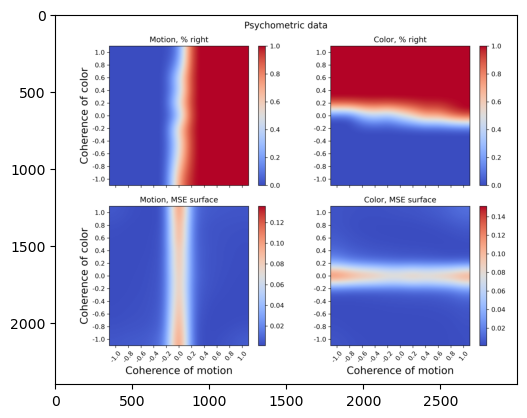

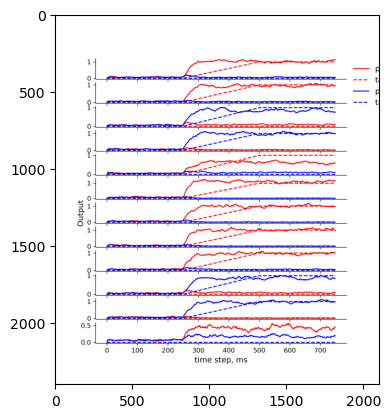

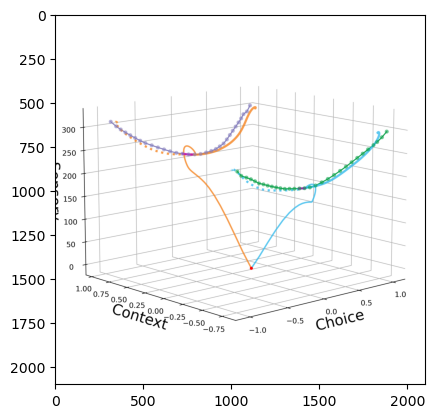

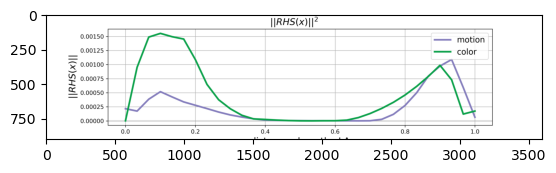

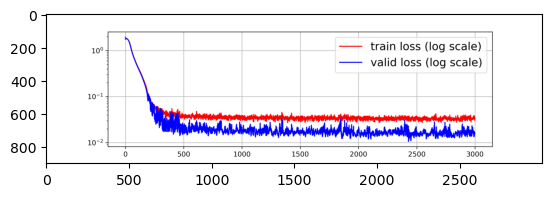

In [322]:
img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_psychometric_data.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_random_trials.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_LA_3D.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_LA_RHS.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(RNN_path, f"{RNN_score}_train&valid_loss.png"), 'rb+'))
plt.imshow(img)
plt.show()


In [323]:
RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_{task_name}.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))

In [324]:
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)

if activation == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation == 'tanh':
    activation_RNN = torch.tanh
elif activation == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))

seed: 105806


In [325]:
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]
dt = RNN_config_file["dt"]
tau = RNN_config_file["tau"]

In [327]:
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)

RNN = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN.set_params(RNN_params)

RNN.sigma_rec = RNN.sigma_inp = torch.tensor(0, device=RNN.device)
y, predicted_output_rnn = RNN(torch.from_numpy(input_batch.astype("float32")))

Using cpu for RNN!


In [328]:
Y = np.hstack([y.detach().numpy()[:, :, i] for i in range(y.shape[-1])])

In [329]:
Y_mean = np.mean(np.abs(Y), axis=1)
th = np.percentile(Y_mean, 20)
inds_fr = np.where(Y_mean > th)[0]

In [330]:
inds_fr

array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 22, 23, 25, 26, 28, 30, 32, 33, 38, 40, 41, 42, 44, 45, 48,
       50, 51, 52, 53, 54, 55, 56, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93])

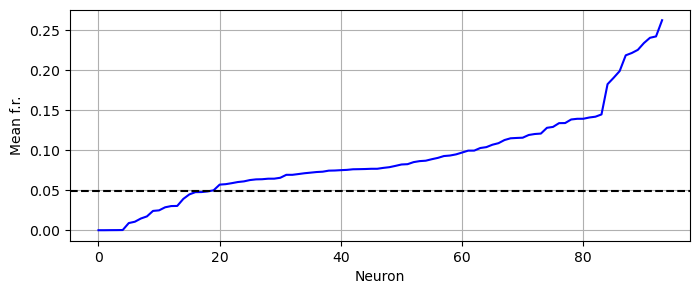

In [332]:
fig = plt.figure(figsize = (8,3))
plt.plot(np.sort(Y_mean), color = 'b')
plt.axhline(th, linestyle='--', color='k')
plt.ylabel("Mean f.r.")
plt.xlabel("Neuron")
plt.grid(True)
plt.show()

In [333]:
# traces should have dimensions of Trials x N x timesteps
traces_full = np.swapaxes(np.swapaxes(y.detach().numpy(), 0, -1), 1, -1)
traces_filt = traces_full[:, inds_fr, :]

In [334]:
traces_z = deepcopy(traces_filt)
for i in range(traces_filt.shape[0]): #trials
    for j in range(traces_filt.shape[1]): # neurons
        mean = np.mean(traces_filt[i, j, :])
        if mean == 0.0:
            tr = 0 * np.ones(traces_z.shape[-1])
        else:
            tr = (traces_filt[i, j, :] - np.min(traces_filt[i, j, :]))/(np.max(traces_filt[i, j, :]) - np.min(traces_filt[i, j, :]))
        traces_z[i, j, :] = deepcopy(tr)

In [335]:
n_t = traces_full.shape[1]
W_rec_reduced = W_rec[:, inds_fr]
W_rec_reduced = W_rec_reduced[inds_fr, :]
features1 = np.mean(traces_z[:, :, :n_t//3], axis = 0)
features2 = np.mean(traces_z[:, :, 2 * (n_t//3):], axis = 0)
features3 = np.mean(traces_filt[:, :, :], axis = 0)
features4 = np.mean(W_rec_reduced, axis = 0).reshape(-1, 1)
feature_mat = np.hstack([eval(f"features{i}") for i in range(1, 4)])

In [336]:
feature_mat.shape

(75, 1469)

In [337]:
pca = PCA(n_components=7)
pca.fit(feature_mat)

PCA(n_components=7)

In [338]:
pca.explained_variance_ratio_

array([0.71493   , 0.15237519, 0.10374955, 0.01898062, 0.00433037,
       0.00265199, 0.00176502], dtype=float32)

In [339]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3, gen_min_span_tree=True, metric='infinity')
clusterer.fit(feature_mat)

HDBSCAN(gen_min_span_tree=True, metric='infinity', min_cluster_size=3)

In [340]:
lbls = clusterer.labels_

In [341]:
lbls

array([-1,  3,  4,  3,  3,  3,  3,  2,  4,  3,  3,  2,  3,  3,  3,  3,  3,
        3,  3, -1, -1, -1,  3,  3,  4,  4,  4,  4,  3,  3,  3,  3,  2,  3,
        3,  3,  3,  3,  3,  2,  3,  3, -1, -1,  2,  3,  3,  3, -1, -1, -1,
        3,  3,  2,  3,  0,  0, -1, -1,  1,  0,  0,  1,  0,  0,  0, -1, -1,
        0,  0, -1, -1, -1,  1, -1])

In [342]:
feature_mat_reduced = feature_mat @ pca.components_.T

In [354]:
%matplotlib notebook
import pandas as pd
colors = ['r', 'lightgreen', 'lightblue', 'yellow', 'orange', 'magenta', 'cyan', 'pink', 'k', 'gray']
fig = px.scatter()
dct = {"xs": [], "ys" : [], "zs" : [], "ind" : [], "cluster" : [], "color" : []}
for i, lbl in enumerate(lbls):
    dct["xs"].append(feature_mat_reduced[i, 0])
    dct["ys"].append(feature_mat_reduced[i, 1])
    dct["zs"].append(feature_mat_reduced[i, 2])
    dct["ind"].append(inds_fr[i])
    dct["cluster"].append(lbl)
    dct["color"].append(colors[lbl])
df = pd.DataFrame(dct)

fig = px.scatter(df, x="xs", y='ys', color='color', hover_data=["cluster", "ind"])
fig.update_layout(
    hoverlabel={
        "bgcolor":"white",
        "font_size":16,
        "font_family":"Rockwell"}
)
fig.show()

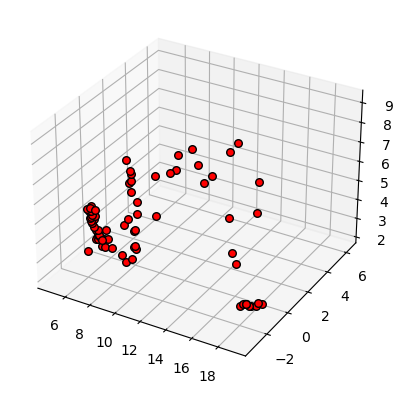

In [344]:
# %matplotlib notebook
colors = ['r', 'lightgreen', 'lightblue', 'yellow', 'orange', 'magenta', 'cyan', 'pink', 'k']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i, lbl in enumerate(lbls):
    xs = feature_mat_reduced[i, 0]
    ys = feature_mat_reduced[i, 1]
    zs = feature_mat_reduced[i, 2]
    cs = feature_mat_reduced[i, 3]
#     ax.scatter(xs, ys, zs, color=colors[lbl], edgecolor='k')
    ax.scatter(xs, ys, zs, color='r', s=30, edgecolor='k')
plt.show()

In [345]:
def plot_neurons_stats(traces, num_nrn, conditions, cohrences_list):
    neural_traces = traces[:, num_nrn, :]
    contexts = np.array([1 if d["context"]=='motion' else 0 for d in conditions])
    motion_coherences = np.array([d["motion_coh"] for d in conditions])
    color_coherences = np.array([d["color_coh"] for d in conditions])
    inds_motion_ctxt = np.where(contexts==1)[0]
    inds_color_ctxt = np.where(contexts==0)[0]

    data_dict = {}
    for ctx in ["motion", "color"]:
        val = 1 if ctx == 'motion' else 0
        inds_context = np.where(contexts==val)[0]
        for part in ["start", "end"]:
            if part == 'start':
                mfr = np.mean(neural_traces[inds_context, :n_steps//3], axis = 1)
            elif part == 'end':
                mfr = np.mean(neural_traces[inds_context, n_steps//3:], axis = 1)

            M = np.zeros((len(cohrences_list), len(cohrences_list)))
            for i in range(len(mfr)):
                coh_motion = np.take(motion_coherences, inds_context)[i]
                coh_color = np.take(color_coherences, inds_context)[i]
                i1 = np.where(cohrences_list == coh_motion)[0][0]
                i2 = np.where(cohrences_list == coh_color)[0][0]
                M[i1, i2] = mfr[i]
            data_dict[(ctx, part)] = deepcopy(M)
            
    figure, ax = plt.subplots(2, 2, figsize = (7, 7))
    plt.suptitle("Neural responses")
    imgs = []
    for i, ctx in enumerate(["motion", "color"]):
        for j, part in enumerate(["start", "end"]):
            imgs.append(ax[j, i].imshow(data_dict[(ctx, part)], cmap = 'coolwarm', vmin = 0, interpolation='bicubic'))
            ax[j, i].set_xticks(np.arange(len(cohrences_list)), cohrences_list, rotation = 50, fontsize = 6)
            ax[j, i].set_yticks(np.arange(len(cohrences_list)), cohrences_list, rotation = 50, fontsize = 6)
            ax[j, i].set_xlabel("Color")
            ax[j, i].set_ylabel("Motion")

    cnt = 0
    for i, ctx in enumerate(["motion", "color"]):
        for j, part in enumerate(["start", "end"]):        
            figure.colorbar(imgs[cnt], ax=ax[j, i], cax=ax[j, i].inset_axes([1.05, 0, 0.05, 1]))
            cnt+=1

    plt.subplots_adjust(hspace = 0.4, wspace = 0.65)
    plt.show()

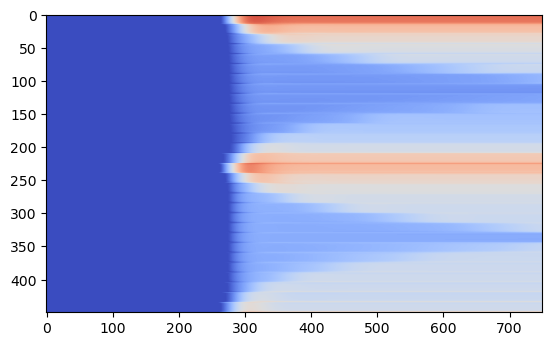

In [346]:
plt.imshow(traces_full[:, 80, :], cmap = 'coolwarm')

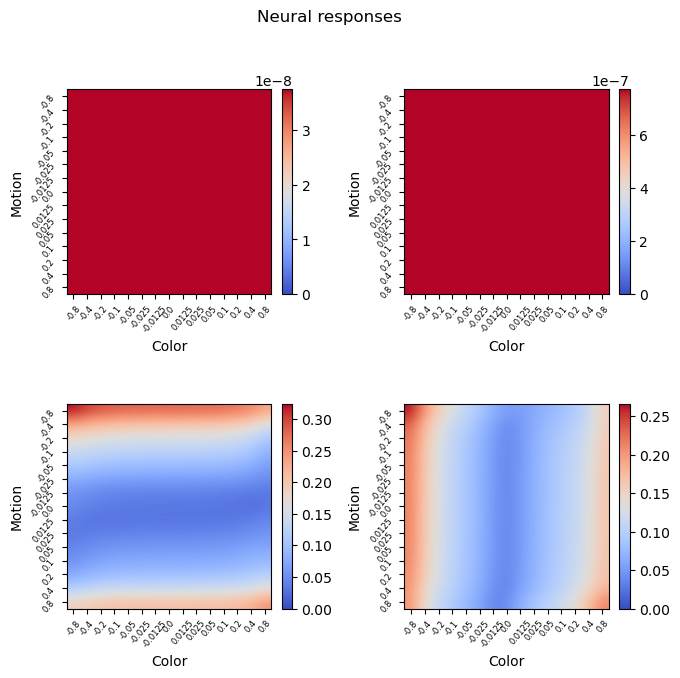

In [347]:
num_nrn = 88
plot_neurons_stats(traces=traces_full, num_nrn=num_nrn, conditions=conditions_batch, cohrences_list=task_params["coherences"])

# loading cluster dict (produced by plotting_neuron_space.py in PyCharm)

In [348]:
cluster_dict = pickle.load(open(os.path.join('../', '../', "rnn_coach", "data", "neurons_clustered.pkl"), "rb+"))

In [349]:
cluster_dict.keys()

dict_keys(['cRaux', 'cR', 'mLaux', 'cL', 'mRaux', 'cLaux', 'mR'])

In [350]:
# refactor this dict so it goes RNN by RNN
new_cluster_dict = {}
labels = ["mR", "mL", "cR", "cL", "mRaux", "mLaux", "cRaux", "cLaux", "context_init", "unsuppressed", "OutR", "OutL"]
for i in range(len(cluster_dict["context_init"].keys()) - 2):
    new_cluster_dict[f"RNN{i}"] = {}
    for label in labels:
        new_cluster_dict[f"RNN{i}"][label] = cluster_dict[label][f"RNN{i}"]

KeyError: 'context_init'

In [351]:
new_cluster_dict.keys()

dict_keys([])

# Figure out the average connectivity between the clusters

In [352]:
Conntectivity_dct = {}
for label1 in labels:
    for label2 in labels:
        Conntectivity_dct[(label1, label2)] = []

In [353]:
# now you go through all the RNNs one by one, load their matrices and get 

task_name = "CDDM"
RNNs_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name)
RNNs = []
for folder in os.listdir(os.path.join('../', "data", "trained_RNNs", task_name)):
    if (folder == '.DS_Store'):
        pass
    else:
        if "relu" in folder:
            RNNs.append(folder)

names = []
scores = []
Ns = []
lmbdos = []
lmbdrs = []
lrs = []
activations = []
tags = []
maxiters = []
dates = []
for folder in RNNs:
    day = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%d')
    month = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%m')
    year = datetime.datetime.fromtimestamp(os.path.getmtime(os.path.join(RNNs_path, folder))).strftime('%Y')
    if (float(month) >= 4) and (float(day) >=23):
        files = os.listdir(os.path.join(RNNs_path, folder))
        config_file = None
        for file in files:
            if "config" in file:
                config_file = file
        config_data = json.load(open(os.path.join(RNNs_path, folder, config_file), "rb+"))
        score = np.round(float(config_file.split("_")[0]), 7)
        activation = config_data["activation"]
        N = config_data["N"]
        lmbdo = config_data["lambda_orth"]
        lmbdr = config_data["lambda_r"]
        lr=config_data["lr"]
        maxiter=config_data["max_iter"]
        extra_info = f"{task_name};{activation};N={N};lmbdo={lmbdo};lmbdr={lmbdr};lr={lr};maxiter={maxiter}"
        name = f"{score}_{extra_info}"
        tag = config_data["tag"]
        names.append(name)
        scores.append(score)
        Ns.append(N)
        lmbdos.append(lmbdo)
        lmbdrs.append(lmbdr)
        lrs.append(lr)
        tags.append(tag)
        activations.append(activation)
        maxiters.append(maxiter)
        dates.append(f"{day}/{month}/{year}")
df = pd.DataFrame({"name" : names, "scores" : scores, "N" : Ns, "date": dates, "activation": activations, "lmbdo" : lmbdos, "lmbdr": lmbdrs, "lr" : lrs, "maxiter" : maxiters})
# additional filtering
# df = df[df['lr'] == 0.005]
df = df[df['maxiter'] == 3000]

pd.set_option('display.max_rows', None)
df.sort_values("scores")
top_RNNs = df.sort_values("scores")["name"].tolist()[:50]
feature_mats = []
RNN_labels = []
true_indices = []
for num_rnn in range(len(top_RNNs)):
    RNN_subfolder = top_RNNs[num_rnn]
    RNN_score = float(top_RNNs[num_rnn].split("_")[0])
    RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", task_name, RNN_subfolder)

    RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_{task_name}.json"), "rb+"))
    RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))

    seed = np.random.randint(1000000)
    print(f"seed: {seed}")
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    rng = torch.Generator(device=torch.device(device))
    if not seed is None:
        rng.manual_seed(seed)

    match activation:
        case 'relu': activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
        case 'tanh': activation_RNN = torch.tanh
        case 'sigmoid': activation_RNN = lambda x: 1 / (1 + torch.exp(-x))
        case 'softplus': lambda x: torch.log(1 + torch.exp(5 * x))

    W_out = np.array(RNN_data["W_out"])
    W_rec = np.array(RNN_data["W_rec"])
    W_inp = np.array(RNN_data["W_inp"])
    bias_rec = np.array(RNN_data["bias_rec"])
    y_init = np.array(RNN_data["y_init"])
    activation = RNN_config_file["activation"]
    mask = np.array(RNN_config_file["mask"])
    input_size = RNN_config_file["num_inputs"]
    output_size = RNN_config_file["num_outputs"]
    task_params = RNN_config_file["task_params"]
    n_steps = task_params["n_steps"]
    sigma_inp = RNN_config_file["sigma_inp"]
    sigma_rec = RNN_config_file["sigma_rec"]
    dt = RNN_config_file["dt"]
    tau = RNN_config_file["tau"]
    
    # now you have to go through the new_cluster_dict
    for label1 in labels:
        indices1 = new_cluster_dict[f"RNN{num_rnn}"][label1]
        for nrn_ind in indices1:
            outgoing_connections = W_rec[:, nrn_ind]
            for label2 in labels:
                indices2 = new_cluster_dict[f"RNN{num_rnn}"][label2]
                Conntectivity_dct[(label2, label1)].extend(np.take(outgoing_connections, indices2).tolist())

seed: 786116


KeyError: 'RNN0'

In [19]:
avg_connectivity = {}
for key in (Conntectivity_dct.keys()):
    connections = Conntectivity_dct[key]
    if len(connections) == 0:
        avg_connectivity[key] = 0
    else:
        avg_connectivity[key] = np.mean(connections)

In [20]:
M = np.zeros((12,12))
for i, label1 in enumerate(labels):
    for j, label2 in enumerate(labels):
        M[i, j] = avg_connectivity[(label1, label2)]

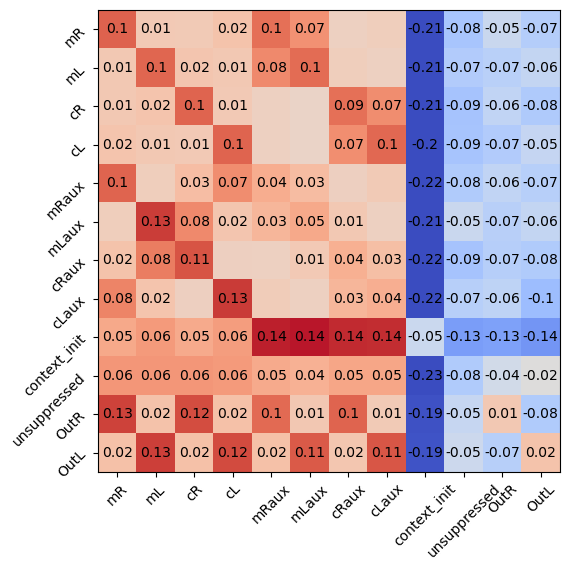

In [21]:
mat = M#/np.max(M)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.imshow(mat, cmap='coolwarm', vmin = -0.2, vmax = 0.15)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) < 0.01:
        pass
    else:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
ax.set_xticks(np.arange(12), labels, rotation=45)
ax.set_yticks(np.arange(12), labels, rotation=45)
plt.show()